# HW3
## Madusanka Madiligama

# What can we change about the NN to improve model performance?

In [1]:
import torch, torchvision
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from torch import nn

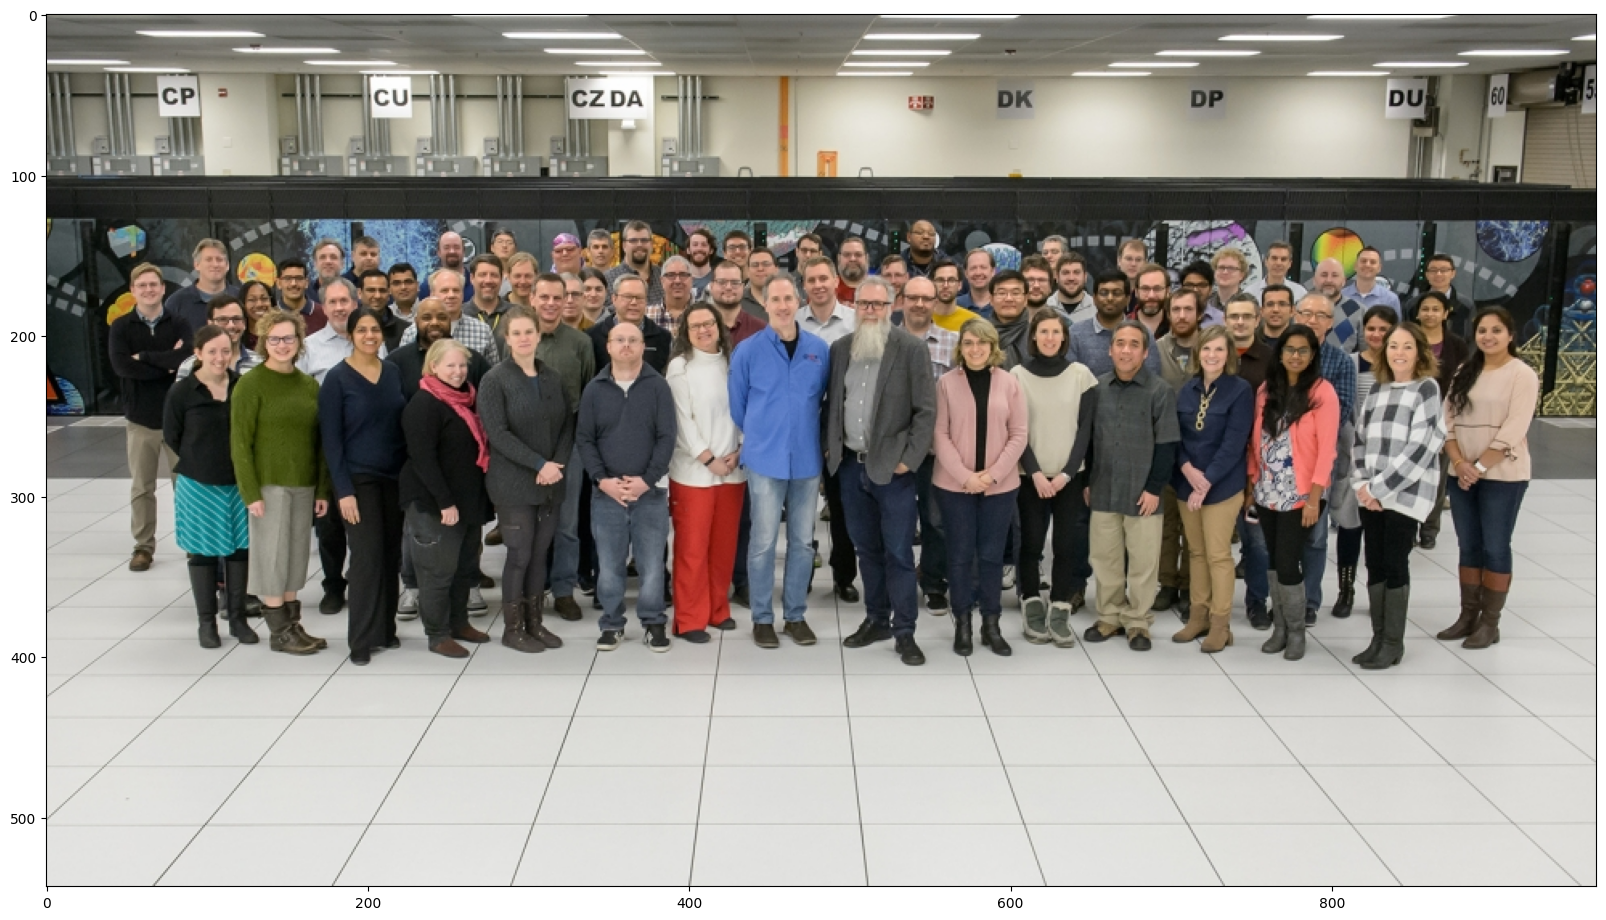

In [2]:
#load the image
alcf_image = Image.open("ALCF-Staff.jpg")
figure = plt.figure(figsize=(20,20))
plt.imshow(alcf_image)
plt.show()

In [3]:
#functions
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):


        return self.downsample(self.norm(inputs))
        
        

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)
        
        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()      

        progress_bar.update()

def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()
            
    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss

In [4]:
#load data and dataloaders to iterate over
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
     root="/lus/eagle/projects/datasets/CIFAR-10/",
    download=False,
    # root="data",
    # download=True,
    train=True,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
     root="/lus/eagle/projects/datasets/CIFAR-10/",
   download=False,
    # root="data",
    # download=True,
    train=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=2)
val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=2)

/soft/applications/conda/2024-04-29/mconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
#stuff for GPU
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)


In [6]:
#print a summary of the model
model = Classifier(32, 4, 2).to(device=dev)

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))


Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 32, 32]         128
├─LayerNorm: 1-2                         [128, 32, 32, 32]         65,536
├─Sequential: 1-3                        [128, 256, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-2               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-3                  [128, 128, 32, 32]        4,224
│    │    └─Conv2d: 3-4                  [128, 32, 32, 32]         4,128
│    └─ConvNextBlock: 2-2                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-6               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-7                  [128, 128, 32, 32] 

In [7]:
#apply the change that we want
#we've added a 4th convolution in ConvNextBlock, along with another non-linear activation function right before it

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )

        #adding one more convolution for testing
        self.conv4 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )

    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # adding another non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        #adding another convolution for testing
        x = self.conv4(x)
        
        # This makes it a residual network:
        return x + inputs

In [8]:
#see how the model performs with the addition on one more activation function and convolution in the ConvNextBlock: 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01)

epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)
    
    # checking on the training & validation loss & accuracy 
    # for training data - only once every 5 epochs (takes a while) 
    if j % 5 == 0:
        with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
            acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
            print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
            
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

/soft/applications/conda/2024-04-29/mconda3/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/soft/applications/conda/2024-04-29/mconda3/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 2.168, accuracy: 17.996


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 2.177, accuracy: 18.018


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 2.074, accuracy: 23.744


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.994, accuracy: 26.830


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.908, accuracy: 30.489


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.890, accuracy: 30.746


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 1.814, accuracy: 34.914


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.817, accuracy: 34.523


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.819, accuracy: 34.286


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 1.771, accuracy: 35.720


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.708, accuracy: 38.054


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 1.694, accuracy: 38.400


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 1.734, accuracy: 37.443


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.747, accuracy: 36.956


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.617, accuracy: 41.545


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 1.629, accuracy: 39.982


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 1.581, accuracy: 42.900


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 1.553, accuracy: 42.771


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 1.607, accuracy: 41.571


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 1.600, accuracy: 41.752


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 1.554, accuracy: 43.799


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 1.578, accuracy: 42.405


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 1.538, accuracy: 43.839


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 1.474, accuracy: 45.787


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 1.510, accuracy: 44.736


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 1.509, accuracy: 44.561


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 1.523, accuracy: 44.314


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 1.452, accuracy: 47.419


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 1.435, accuracy: 48.319


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 1.433, accuracy: 48.546


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 1.400, accuracy: 50.010


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 1.406, accuracy: 49.328


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 1.401, accuracy: 49.822


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 1.446, accuracy: 47.310


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 1.428, accuracy: 47.419


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 1.413, accuracy: 49.169


In [9]:
#apply the change that we want
#we've added a 4th convolution in ConvNextBlock, along with another non-linear activation function right before it

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )
         #adding two more convolutions for testing
        
        self.conv4 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )

       
        self.conv5 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )

    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # adding another non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        #adding another convolution for testing
        x = self.conv4(x)

        # adding another non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        #adding another convolution for testing
        x = self.conv5(x)
        
        # This makes it a residual network:
        return x + inputs

In [10]:
#see how the model performs with the addition on one more activation function and convolution in the ConvNextBlock: 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01)

epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)
    
    # checking on the training & validation loss & accuracy 
    # for training data - only once every 5 epochs (takes a while) 
    if j % 5 == 0:
        with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
            acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
            print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
            
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.401, accuracy: 49.224


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.403, accuracy: 49.070


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.417, accuracy: 48.487


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.361, accuracy: 51.058


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.390, accuracy: 49.980


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.386, accuracy: 50.613


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 1.331, accuracy: 52.441


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.336, accuracy: 51.681


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.353, accuracy: 51.058


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 1.348, accuracy: 51.177


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.339, accuracy: 51.889


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 1.389, accuracy: 49.337


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 1.385, accuracy: 50.359


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.405, accuracy: 49.159


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.350, accuracy: 51.404


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 1.345, accuracy: 51.276


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 1.316, accuracy: 51.830


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 1.314, accuracy: 52.660


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 1.341, accuracy: 52.436


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 1.359, accuracy: 51.216


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 1.304, accuracy: 52.551


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 1.341, accuracy: 52.087


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 1.307, accuracy: 52.601


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 1.316, accuracy: 51.671


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 1.267, accuracy: 54.842


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 1.286, accuracy: 52.957


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 1.301, accuracy: 52.848


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 1.367, accuracy: 51.088


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 1.290, accuracy: 52.720


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 1.270, accuracy: 53.748


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 1.312, accuracy: 52.571


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 1.325, accuracy: 51.543


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 1.313, accuracy: 51.790


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 1.266, accuracy: 54.688


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 1.278, accuracy: 54.371


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 1.329, accuracy: 51.335


In [11]:


class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )

        #adding one more convolution for testing
        self.conv4 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )

    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        #adding another convolution for testing
        x = self.conv4(x)
        
        # This makes it a residual network:
        return x + inputs



#print a summary of the model
model = Classifier(32, 4, 2).to(device=dev)

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))


#see how the model performs with the addition of only one convolution in the ConvNextBlock: 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01)

epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)
    
    # checking on the training & validation loss & accuracy 
    # for training data - only once every 5 epochs (takes a while) 
    if j % 5 == 0:
        with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
            acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
            print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
            
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 32, 32]         128
├─LayerNorm: 1-2                         [128, 32, 32, 32]         65,536
├─Sequential: 1-3                        [128, 256, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-2               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-3                  [128, 128, 32, 32]        4,224
│    │    └─Conv2d: 3-4                  [128, 32, 32, 32]         4,128
│    │    └─Conv2d: 3-5                  [128, 32, 32, 32]         1,056
│    └─ConvNextBlock: 2-2                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-6                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-7               [128, 32, 32, 32]   

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 2.161, accuracy: 20.103


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 2.167, accuracy: 19.591


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 2.052, accuracy: 23.912


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 2.003, accuracy: 26.375


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.989, accuracy: 27.097


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.942, accuracy: 28.105


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 1.883, accuracy: 32.376


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.883, accuracy: 31.715


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.886, accuracy: 31.329


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 1.845, accuracy: 32.812


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.877, accuracy: 30.686


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 1.825, accuracy: 33.673


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 1.792, accuracy: 36.230


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.795, accuracy: 35.700


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.760, accuracy: 36.086


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 1.756, accuracy: 36.837


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 1.747, accuracy: 35.512


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 1.693, accuracy: 38.192


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 1.740, accuracy: 36.090


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 1.739, accuracy: 36.027


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 1.655, accuracy: 39.250


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 1.641, accuracy: 40.210


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 1.624, accuracy: 40.951


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 1.661, accuracy: 39.577


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 1.642, accuracy: 40.490


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 1.638, accuracy: 39.765


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 1.623, accuracy: 41.663


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 1.594, accuracy: 42.059


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 1.568, accuracy: 42.751


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 1.599, accuracy: 41.485


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 1.571, accuracy: 43.495


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 1.567, accuracy: 43.414


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 1.533, accuracy: 44.076


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 1.535, accuracy: 44.264


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 1.540, accuracy: 43.453


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 1.534, accuracy: 44.353


In [10]:

batch_size = 64

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=2)
val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=2)

train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)


class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )

        #adding one more convolution for testing
        # self.conv4 = nn.Conv2d(in_channels=in_channels, 
        #                              out_channels=in_channels,
        #                              kernel_size=1
        #                              )
        
    
    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        #adding another convolution for testing
        # x = self.conv4(x)

        # This makes it a residual network:
        return x + inputs



#print a summary of the model
model = Classifier(32, 4, 2).to(device=dev)

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))


#see how the model performs with the addition of only one convolution in the ConvNextBlock: 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01)

epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)
    
    # checking on the training & validation loss & accuracy 
    # for training data - only once every 5 epochs (takes a while) 
    if j % 5 == 0:
        with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
            acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
            print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
            
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 32, 32]          128
├─LayerNorm: 1-2                         [64, 32, 32, 32]          65,536
├─Sequential: 1-3                        [64, 256, 4, 4]           --
│    └─ConvNextBlock: 2-1                [64, 32, 32, 32]          --
│    │    └─Conv2d: 3-1                  [64, 32, 32, 32]          1,600
│    │    └─LayerNorm: 3-2               [64, 32, 32, 32]          65,536
│    │    └─Conv2d: 3-3                  [64, 128, 32, 32]         4,224
│    │    └─Conv2d: 3-4                  [64, 32, 32, 32]          4,128
│    └─ConvNextBlock: 2-2                [64, 32, 32, 32]          --
│    │    └─Conv2d: 3-5                  [64, 32, 32, 32]          1,600
│    │    └─LayerNorm: 3-6               [64, 32, 32, 32]          65,536
│    │    └─Conv2d: 3-7                  [64, 128, 32, 32]  

Train Epoch 0:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 0: training loss: 2.048, accuracy: 23.555


Validate Epoch 0:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0: validation loss: 2.049, accuracy: 23.099


Train Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.905, accuracy: 30.454


Train Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.816, accuracy: 34.942


Train Epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.778, accuracy: 35.231


Train Epoch 4:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.721, accuracy: 37.410


Train Epoch 5:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5: training loss: 1.639, accuracy: 41.442


Validate Epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.633, accuracy: 41.610


Train Epoch 6:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.603, accuracy: 42.247


Train Epoch 7:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7: validation loss: 1.603, accuracy: 41.879


Train Epoch 8:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.558, accuracy: 43.760


Train Epoch 9:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9: validation loss: 1.554, accuracy: 44.019


Train Epoch 10:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 10: training loss: 1.520, accuracy: 45.920


Validate Epoch 10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.523, accuracy: 44.815


Train Epoch 11:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.521, accuracy: 45.283


Train Epoch 12:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12: validation loss: 1.470, accuracy: 46.646


Train Epoch 13:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13: validation loss: 1.442, accuracy: 47.830


Train Epoch 14:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14: validation loss: 1.462, accuracy: 46.616


Train Epoch 15:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 15: training loss: 1.419, accuracy: 48.828


Validate Epoch 15:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15: validation loss: 1.420, accuracy: 49.104


Train Epoch 16:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 16:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16: validation loss: 1.406, accuracy: 49.094


Train Epoch 17:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 17:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17: validation loss: 1.401, accuracy: 49.134


Train Epoch 18:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 18:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18: validation loss: 1.390, accuracy: 49.930


Train Epoch 19:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 19:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19: validation loss: 1.379, accuracy: 50.299


Train Epoch 20:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 20: training loss: 1.349, accuracy: 52.182


Validate Epoch 20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20: validation loss: 1.360, accuracy: 50.806


Train Epoch 21:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 21:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 21: validation loss: 1.371, accuracy: 50.786


Train Epoch 22:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 22:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 22: validation loss: 1.350, accuracy: 51.274


Train Epoch 23:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 23:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 23: validation loss: 1.330, accuracy: 52.418


Train Epoch 24:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 24:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 24: validation loss: 1.323, accuracy: 51.871


Train Epoch 25:   0%|          | 0/625 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 25: training loss: 1.378, accuracy: 50.758


Validate Epoch 25:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 25: validation loss: 1.394, accuracy: 48.786


Train Epoch 26:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 26:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 26: validation loss: 1.315, accuracy: 52.329


Train Epoch 27:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 27:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 27: validation loss: 1.334, accuracy: 52.538


Train Epoch 28:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 28:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 28: validation loss: 1.302, accuracy: 53.155


Train Epoch 29:   0%|          | 0/625 [00:00<?, ?it/s]

Validate Epoch 29:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 29: validation loss: 1.305, accuracy: 52.956


In [11]:
#how does the model perform on the test data?
batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, 
    batch_size=batch_size_test, 
    pin_memory=True,
    shuffle=True, 
    num_workers=2)

with tqdm(total=len(test_dataloader), position=0, leave=True) as val_bar:

    acc_test, loss_test = evaluate(val_dataloader, model, loss_fn, val_bar)
# acc_test, loss_test = evaluate(test_dataloader, model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

  0%|          | 0/40 [00:00<?, ?it/s]

Test loss: 1.3042, test accuracy: 53.05%


Benchmark:

Epoch 29: validation loss: 1.446, accuracy: 47.4

Try1: 4 convolution and also applying a second activation function 
Epoch 29: validation loss: 1.413, accuracy: 49.169

Try2: 5 convolution and also applying two additional activation functions 
Epoch 29: validation loss: 1.329, accuracy: 51.335

Try3: 4 convolutions without applying a second activation function 
Epoch 29: validation loss: 1.534, accuracy: 44.353

Tr45: keep original structure. only change btch size to 64aEpoch 29: validation loss: 1.305, accuracy: 52.956

Accuracy on test data:
Test loss: 1.3042, test accuracy: 53.05%3 so, beat the benchmark in two different setups. 8